In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [40]:
# import dataset
import os
in_csv_files = []
for dirname, _, filenames in os.walk('./IDS Dataset'):
    for filename in filenames:
        csv_file = os.path.join(dirname, filename)
        print(os.path.join(dirname, filename))
        in_csv_files.append(csv_file)

./IDS Dataset\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
./IDS Dataset\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
./IDS Dataset\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv


In [41]:
# cleaning dataframe
df = pd.concat([pd.read_csv(file) for file in in_csv_files], ignore_index=True)
df.columns = df.columns.str.strip()
print("original length of df:", len(df))
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print("after droping null values, the length of df:", len(df))

original length of df: 684713
after droping null values, the length of df: 684337


In [43]:
df.Label.value_counts()

BENIGN                        554096
DDoS                          128025
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Name: Label, dtype: int64

In [44]:
# Clean/replace Label names
df_experiment = df.copy()
df_experiment.Label.replace("Web.*", "Web Attack", regex=True, inplace=True)
df_experiment.Label.replace(r'.*Patator$', "Brute Force", regex=True,inplace=True)
df_experiment.Label.value_counts()

BENIGN          554096
DDoS            128025
Web Attack        2180
Infiltration        36
Name: Label, dtype: int64

In [45]:
del df

In [55]:
# data split train and test in ratio 7:3
from sklearn.model_selection import train_test_split
from collections import Counter
y = df_experiment.Label
X = df_experiment.drop(columns='Label')
labels = y.unique()
classes = y.nunique()
print(X.shape)
print("toal labels:", classes)
print("count per label\n", y.value_counts())
print("labels:", labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print("AFTER SPLIT- Training data length:", len(X_train))
print("AFTER SPLIT- Test data length:", len(X_test))

(684337, 78)
toal labels: 4
count per label
 BENIGN          554096
DDoS            128025
Web Attack        2180
Infiltration        36
Name: Label, dtype: int64
labels: ['BENIGN' 'DDoS' 'Infiltration' 'Web Attack']
AFTER SPLIT- Training data length: 458505
AFTER SPLIT- Test data length: 225832


In [56]:
#Feature scaling
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler

scaler = MinMaxScaler()
le = LabelEncoder()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("instances per label in training set\n", y_train.value_counts())
y_train = le.fit_transform(y_train)
print("instances per label in test set\n", y_test.value_counts())
y_test = le.transform(y_test)

print(X_train.shape)
print(X_test.shape)
labels_dict = dict(zip(le.classes_, range(len(le.classes_))))
print(labels_dict)

instances per label in training set
 BENIGN          371267
DDoS             85783
Web Attack        1429
Infiltration        26
Name: Label, dtype: int64
instances per label in test set
 BENIGN          182829
DDoS             42242
Web Attack         751
Infiltration        10
Name: Label, dtype: int64
(458505, 78)
(225832, 78)
{'BENIGN': 0, 'DDoS': 1, 'Infiltration': 2, 'Web Attack': 3}


In [9]:
import imblearn

C:\Anaconda\anaconda3\lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Counter({1: 371267, 0: 371267, 3: 371267, 2: 371267})
Counter({1: 371267, 0: 371267, 3: 371267, 2: 371267})


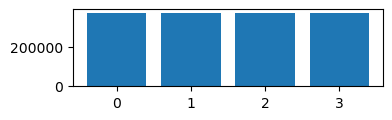

In [57]:
# Data Sampling- SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
# transform the dataset
oversample = SMOTE(sampling_strategy='not majority', n_jobs=-1)
steps = [('o', oversample)]
pipeline = Pipeline(steps=steps)
X_train, y_train = pipeline.fit_resample(X_train, y_train)
counter = Counter(y_train)
print(counter)
# plot the distribution
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(1)
print(counter)
# plot the SMOTE distribution
plt.bar(counter.keys(), counter.values())
plt.show()

Training the model
We define the parameters for the random forest training as follows:

n_estimators: This is the number of trees in the random forest classification. We have defined 10 trees in our random forest.
criterion: This is the loss function used to measure the quality of the split. There are two available options in sklearn — gini and entropy. We have used entropy.
random_state: This is the seed used by the random state generator for randomizing the dataset.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [36]:
# Feature importance
importances = classifier.feature_importances_
df_importance = pd.DataFrame({"names":list(X.columns) ,"importance":importances})
df_importance=df_importance.sort_values('importance',ascending=False).reset_index()
df_importance.head()



,index,names,importance
0,42,Packet Length Variance,0.112576
1,6,Fwd Packet Length Max,0.106183
2,63,Subflow Fwd Bytes,0.096736
3,62,Subflow Fwd Packets,0.086373
4,68,act_data_pkt_fwd,0.067452


In [38]:
df_importance.to_csv('feature_imp.csv', encoding='utf-8')


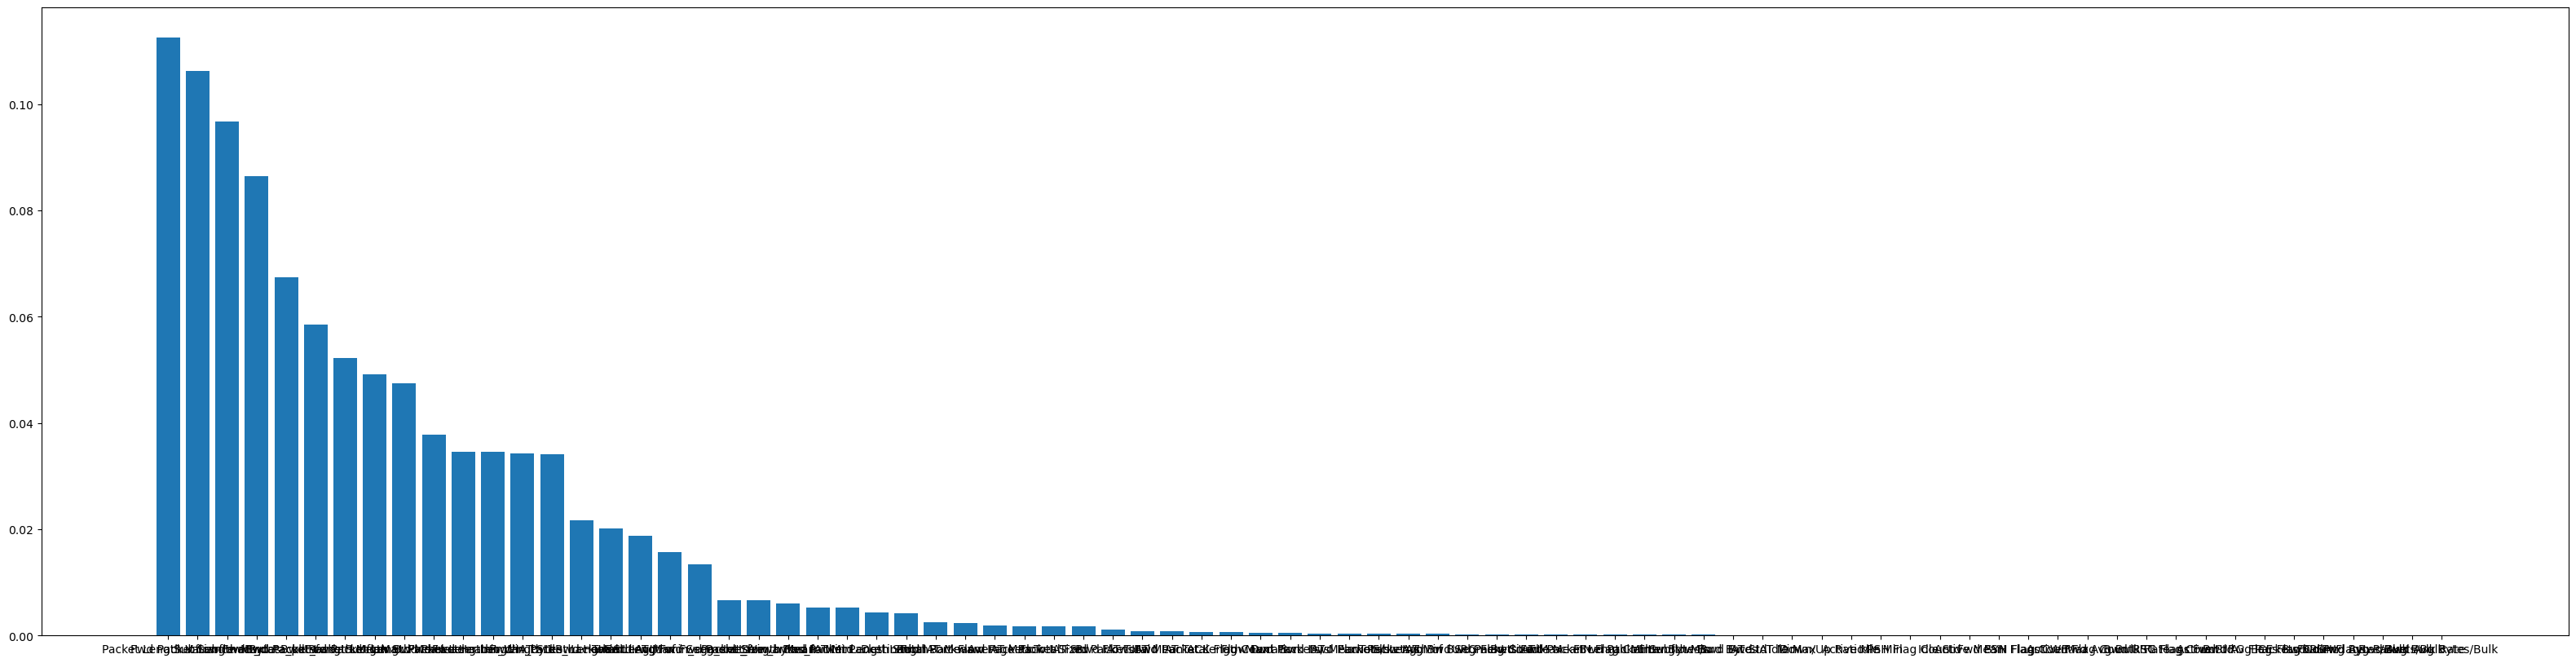

In [24]:
#plot Feature importances chart
import matplotlib.pyplot as plt
f = plt.figure()
f.set_figwidth(40)
f.set_figheight(10)
plt.bar(df_importance.names, df_importance.importance)
plt.show()

In [29]:
# performing predictions on the test dataset
y_pred = classifier.predict(X_test)
  
# metrics are used to find accuracy or error,using metrics module for accuracy calculation
from sklearn import metrics  

print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.9997963087604945


In [31]:
#print the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print("CONFUSION MATRIX :\n", confusion_matrix)



CONFUSION MATRIX :
 [[182824      5      0      0]
 [    20  42222      0      0]
 [     3      0      7      0]
 [    18      0      0    733]]


In [20]:
print(labels_dict)

{'BENIGN': 0, 'DDoS': 1, 'Infiltration': 2, 'Web Attack': 3}


In [22]:
#print the classification report
from sklearn import metrics
classification = metrics.classification_report(y_test, y_pred)
print("Classification report:" "\n", classification) 
print()

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    182829
           1       1.00      1.00      1.00     42242
           2       0.89      0.80      0.84        10
           3       0.87      1.00      0.93       751

    accuracy                           1.00    225832
   macro avg       0.94      0.95      0.94    225832
weighted avg       1.00      1.00      1.00    225832


